# Suitability Analysis: Best place within the Boston Region for a Tufts UEP student and BU Law student to live without a car 
UEP-239 Final Project\
By: Justina Cheng

[DESCRIPTION]

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
from pyproj import CRS
from shapely.geometry import LineString, Point, Polygon, box

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

## View base map

In [2]:
mpo = gpd.read_file("./data/MPO_Boundaries/MPO_Boundaries.shp")
mpo

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


<AxesSubplot:>

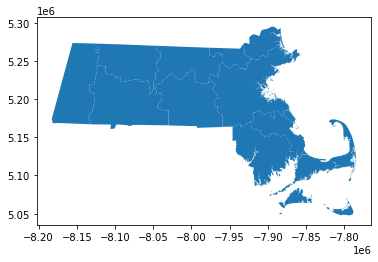

In [3]:
mpo.plot()


In [4]:
ma_zcta = gpd.read_file("./data/tl_2010_25_zcta500/tl_2010_25_zcta500.shp")
ma_zcta

,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,25,02664,2502664,B5,G6350,S,19132195,361261,+41.6747273,-070.1956478,N,"POLYGON ((-70.21397 41.67049, -70.21416 41.671..."
1,25,02534,2502534,B5,G6350,S,6982729,59105,+41.6690041,-070.6152799,N,"MULTIPOLYGON (((-70.62981 41.66786, -70.62963 ..."
2,25,02657,2502657,B5,G6350,S,25037286,466360,+42.0622998,-070.1993066,N,"MULTIPOLYGON (((-70.23665 42.06287, -70.23676 ..."
3,25,02652,2502652,B5,G6350,S,21757561,46932,+42.0412079,-070.0897345,N,"POLYGON ((-70.14695 42.06466, -70.14691 42.064..."
4,25,02649,2502649,B5,G6350,S,60695300,6578141,+41.6214759,-070.4909354,N,"MULTIPOLYGON (((-70.46531 41.59374, -70.46547 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
496,25,01092,2501092,B5,G6350,S,15776502,58321,+42.2054233,-072.2381709,N,"POLYGON ((-72.26327 42.18367, -72.26388 42.183..."
497,25,01590,2501590,B5,G6350,S,83820605,1836511,+42.1320512,-071.7503180,N,"POLYGON ((-71.70291 42.12743, -71.70305 42.127..."
498,25,01602,2501602,B5,G6350,S,17449148,643169,+42.2713962,-071.8512288,N,"POLYGON ((-71.81415 42.27569, -71.81322 42.276..."
499,25,01608,2501608,B5,G6350,S,1162510,0,+42.2622939,-071.8011444,N,"POLYGON ((-71.80218 42.26344, -71.80204 42.263..."


<AxesSubplot:>

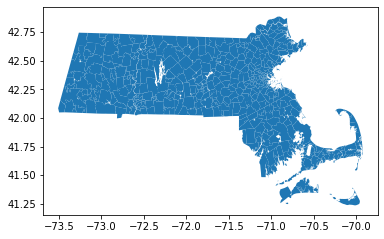

In [5]:
ma_zcta.plot()

## Distance to Necessities/Amenities
Amenities are defined as food/groceries, healthcare institutions (acute care, urgent care, hospitals, etc.), safety (firestations)